# Amazon SageMaker를 활용한 오토스케일링(Autoscaling)

이 노트북은 강화 학습(reinforcement learning) 기술을 사용하여 소프트웨어 시스템의 프로덕션 운영에서 매우 일반적인 문제를 해결하는 방법의 예를 보여줍니다. 이 예제는 실질적이고 까다로운 문제를 어떻게 해결할 수 있는지 보여주는 간단한 예제로, 동적으로 변화하는 로드에 대응하여 리소스(예: 서버 또는 EC2 인스턴스)를 추가 및 제거하여 프로덕션 서비스를 확장합니다. 일별 및 주별 변형 및 간헐적 스파이크로 인위적 데이터를 생성하여 시뮬레이션 시스템을 구축합니다. 또한, 새로운 리소스가 요청되는 시점과 요청을 서빙할 수 있는 시점 사이에 지연이 있습니다. 맞춤형 환경(environment)은 Open AI gym을 사용하여 구성되며 RL 에이전트는 Amazon SageMaker를 사용하여 훈련합니다.

## 문제 정의

오토스케일링을 통해 정의한 조건에 따라 서비스가 자동으로 용량을 자동으로 늘리거나 줄입니다. 이는 알람, 스케일링 정책, 임계값 설정이 포함됩니다. 맞춤형 시뮬레이터에서 오토스케일링에 대한 RL 문제는 다음과 같이 정의할 수 있습니다.

1. *목표(Objective)*: 인스턴스 용량을 로드 프로파일(load profile)에 맞게 조정하여 확장 가능한 웹 서비스의 수익을 최적화합니다. 한편, 스파이크가 발생할 때 서버/인스턴스가 충분한 지 확인하세요.
2. *환경(Environment)*: 로드 프로파일을 포함하는 사용자 정의 개발 환경으로, 매일 및 매주로 변형되고 가끔씩 스파이크가 발생하는 가짜 시뮬레이션 부하를 생성합니다. 시뮬레이션된 시스템에는 새 리소스가 요청되는 시점과 요청을 처리할 수 있는 시점 사이에 지연이 있습니다.
3. *상태(State)* : 이전 관측치와 현재 관측치의 시간 가중 조합입니다. 각 타임 스탬프마다 현재 로드(현재 트랜잭션 수), 실패한 트랜잭션 수, 서비스가 다운 타임 상태인지 여부를 나타내는 boolean 변수 가용성이 99.5 % 아래로 떨어질 때) 및 현재 활성 머신 수가 포함됩니다.
4. *행동(Action)*: 머신을 제거하거나 추가합니다. 에이전트는 동시에 두 가지를 모두 수행할 수 있습니다.
5. *보상(Reward)* : 간단한 재무 모델을 기반으로 한 맞춤형 보상 기능으로 성공적인 트랜잭션에 대한 긍정적인 보상 외에 기계 운영 비용도 고려합니다. 또한, 다운 타임에 높은 페널티를 적용합니다.

## Amazon SageMaker RL 사용법

Amazon SageMaker를 사용하면 도커 컨테이너를 사용하여 클라우드 시스템에서 RL 에이전트를 훈련할 수 있습니다. RL 툴킷 및 딥러닝 프레임워크를 사용하여 머신을 설정하는 것에 대해 걱정할 필요가 없습니다. 큰 속도 향상을 제공하는 강력한 GPU 시스템을 포함하여 여러 다른 시스템 설정 간에 쉽게 인스턴스를 전환할 수 있습니다. 또한 프로덕션 수준의 로드에 필요한 훈련 속도를 높이기 위해 클러스터에서 여러 시스템(인스턴스)을 사용하도록 선택할 수도 있습니다.

## 전제 조건(Pre-requisites)

### 역할(role) 및 권한(permission)

시작하기 위해, 필요한 Python 라이브러리를 가져와서 권한 및 구성을 위한 몇 가지 전제 조건으로 환경을 설정합니다.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### S3 버킷 설정

체크포인트(checkpoint) 및 메타데이터에 사용하려는 S3 버킷에 대한 연결 및 인증을 설정합니다.

In [2]:
# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket) # SDK appends the job name and output folder
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-143656149352/


### 변수 설정

훈련 작업의 작업 접두사(job prefix)와 *컨테이너의 이미지 경로(BYOC 인 경우에만)와 같은 변수*를 정의합니다.

In [3]:
# create unique job name 
job_name_prefix = 'rl-auto-scaling'

### 설정 구성

SageMaker 노트북 인스턴스 또는 자신의 컴퓨터에서 RL 훈련 작업을 실행할 수 있습니다. 이 두 시나리오 모두 `로컬` 또는 `SageMaker` 모드에서 다음을 실행할 수 있습니다. `로컬` 모드는 SageMaker Python SDK를 사용하여 SageMaker에 배포하기 전에 로컬 컨테이너에서 코드를 실행합니다. 이렇게 하면 익숙한 Python SDK 인터페이스를 사용하면서 반복 테스트 및 디버깅 속도를 높일 수 있습니다. `local_mode = True`만 설정하면 됩니다.

In [4]:
%%time

# run in local mode?
local_mode = False

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


### IAM 역할 생성

SageMaker 노트북 `role = sagemaker.get_execution_role()`을 실행할 때 실행 역할(execution role)을 얻거나 로컬 시스템에서 실행할 때 utils 메소드 `role = get_execution_role()`을 사용하여 실행 역할을 작성하세요.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()
    
print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::143656149352:role/service-role/AmazonSageMaker-ExecutionRole-20200323T143836


### `로컬` 모드용 도커 설치

로컬 모드에서 작업하려면 도커(docker)가 설치되어 있어야 합니다. 로컬 머신에서 실행할 때는 docker 또는 docker-compose(로컬 CPU 머신의 경우) 및 nvidia-docker(로컬 GPU 머신의 경우)가 설치되어 있는지 확인하세요. 또는, SageMaker 노트북 인스턴스에서 실행할 때 다음 스크립트를 실행하여 관련 패키지들을 설치할 수 있습니다.

참고로, 한 번에 하나의 로컬 노트북만 실행할 수 있습니다.

In [6]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## 환경 설정

환경은 `autoscalesim.py`라는 Python 파일에 정의되며, 파일은 `/src` 디렉토리에 업로드됩니다.

환경은 또한 환경의 작동 방식을 설명하는 `init()`, `step()` 및 `reset()` 함수를 구현합니다. 이것은 환경을 정의하기 위한 Open AI Gym 인터페이스와 일치합니다.

1. init() - 환경을 미리 정의된 상태로 초기화
2. step() - 환경에 대한 행동 수행
3. reset() - 새로운 에피소드에서 환경을 다시 시작
4. [해당되는 경우] render() - 현재 상태에서 환경의 렌더링된 이미지를 가져옵니다.

In [7]:
!pygmentize src/autoscalesim.py

import numpy as np
import gym
from gym.spaces import Discrete, Box
from gym.envs.registration import EnvSpec
from gymhelper import box_space_from_description


class MultiEma():
    """Utility class that handles multiple streams of exponential moving average (EMA)
    with multiple different alpha values.
    """
    def __init__(self, num_streams, alphas):
        self.alphas = np.asarray(alphas)
        self.num_alphas = self.alphas.shape[0]
        self.num_streams = num_streams
        self.values = np.zeros(shape=(self.num_streams, self.num_alphas))

    def update(self, current):
        """Takes a vector of current observations.  Updates all the EMA streams,
        and returns them in a (N,A) matrix for the N streams and A alpha values.
        """
        decayed = self.values * (1.0 - self.alphas)
        updates = np.outer(np.asarray(current), self.alphas)
        self.values = decayed + updates
        return self.values

class SimpleScalableWebserviceSim(gym.Env):
    """A

## 시뮬레이션된 로드 시각화

시뮬레이션된 로드의 모양은 오토스케일링 시뮬레이션에 중요합니다. 이 toy 로드 시뮬레이터를 시각화에 사용합니다. 시뮬레이터에는 주기적 로드와 스파이크라는 두 가지 구성 요소들이 있습니다. 주기적 로드는 곱셈 가우시안 노이즈와 함께 고정된 평균 및 진폭의 단순한 일일 주기입니다. 스파이크 로드는 즉시 시작되어 사라질 때까지 점진적으로 줄어드며, 가변적인 지연이 있습니다.

In [8]:
# if open AI Gym is not installed
! pip install gym

     |████████████████████████████████| 1.6MB 4.7MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 41.8MB/s eta 0:00:01
     |████████████████████████████████| 829kB 55.9MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.17.1-cp36-none-any.whl size=1648738 sha256=81e36b9d0f2243440381b25359018e85d31227c48bb21b1f6529c2b458f84193
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c0/84/61/523b92d88787ae29689b3cc08cf445d8d8186d7fbe1acbf87b
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491095 sha256=bdcb16ae4683b50b6ca68ae602397c5eb7b1e5a386e9165115f5b3d9f8899da7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built gym future
  Found existing installation: cloudpickle 0.5.3
    Uninstalling cloudpickle-0.5.3:
      Successfully uninstalled cloudpickle-0.5.3
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('src')
import autoscalesim

In [10]:
def xy_data(days_to_simulate=3):
    loadsim = autoscalesim.LoadSimulator()
    load = []
    x = np.arange(0, days_to_simulate, 1.0/(24*60))
    for t in x:
        load.append(loadsim.time_step_load())
    load = np.asarray(load)
    return (x, load)

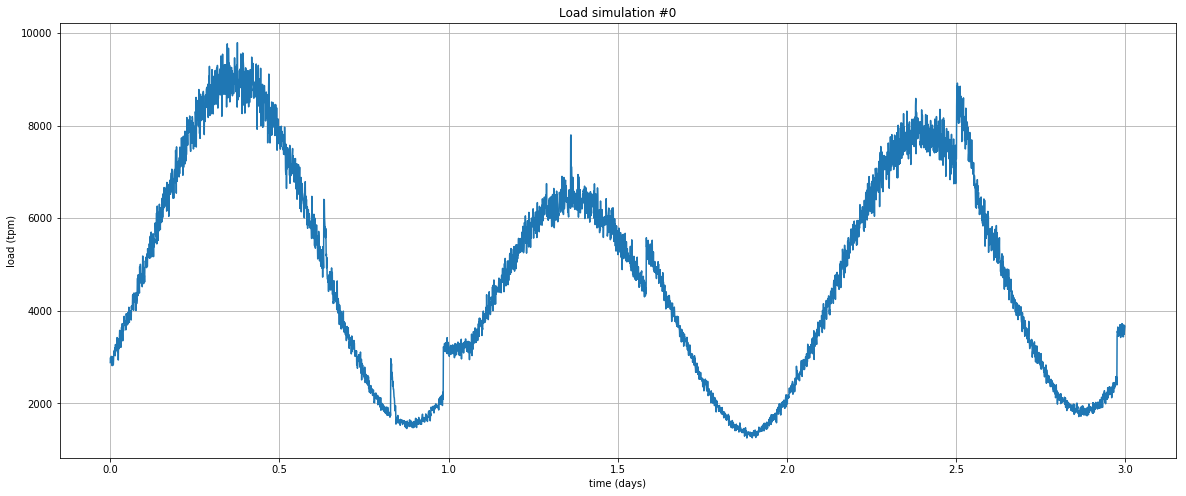

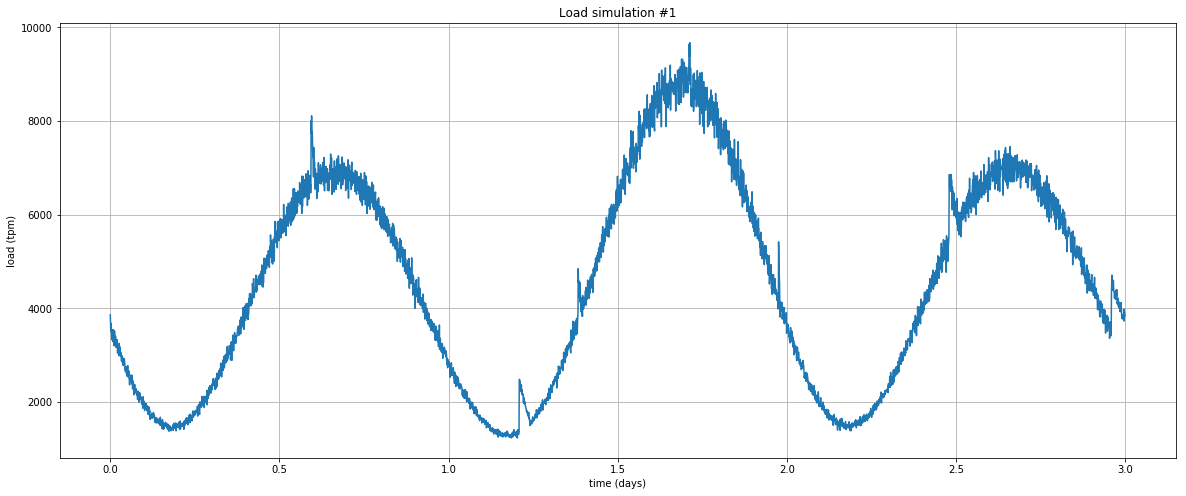

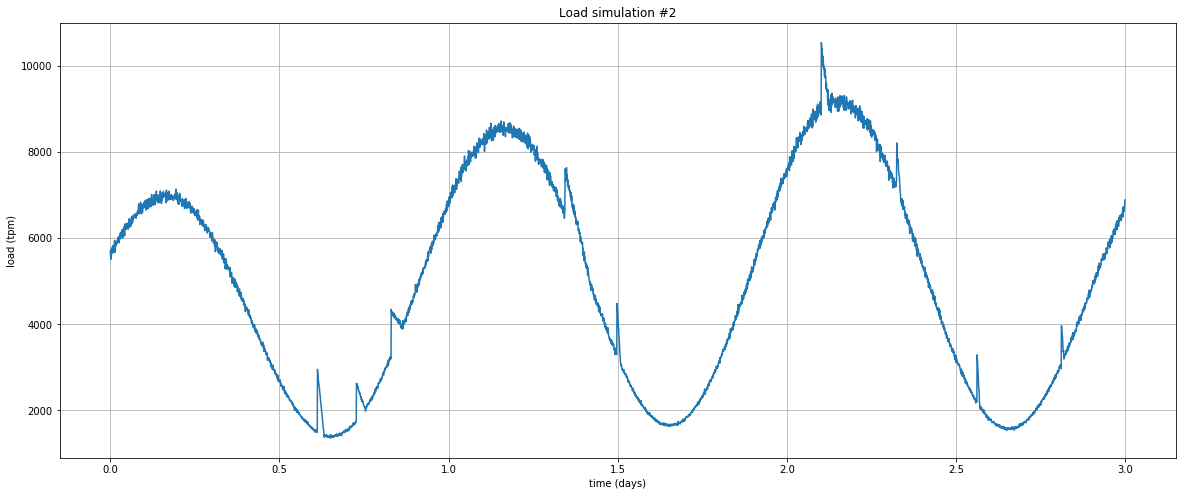

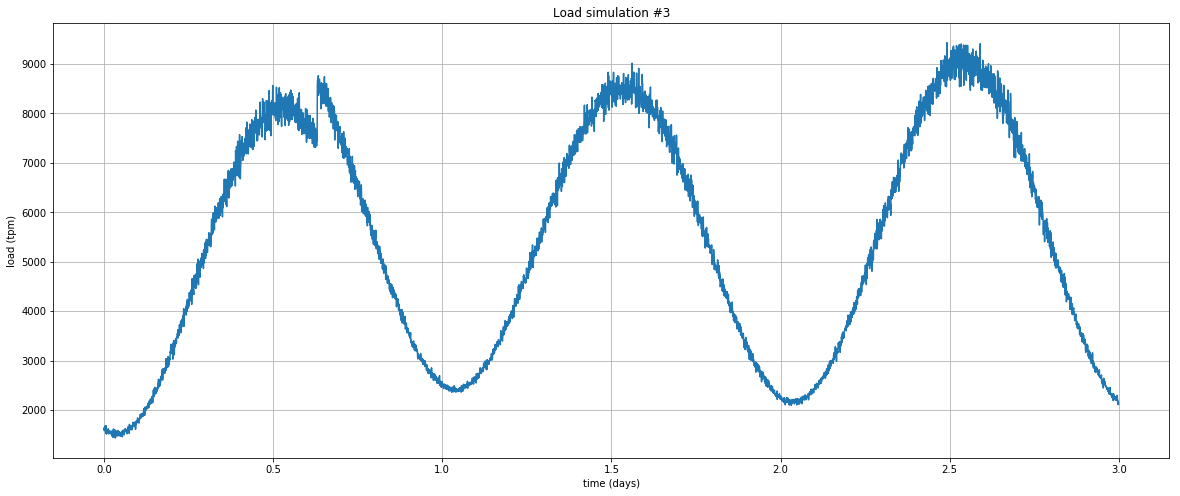

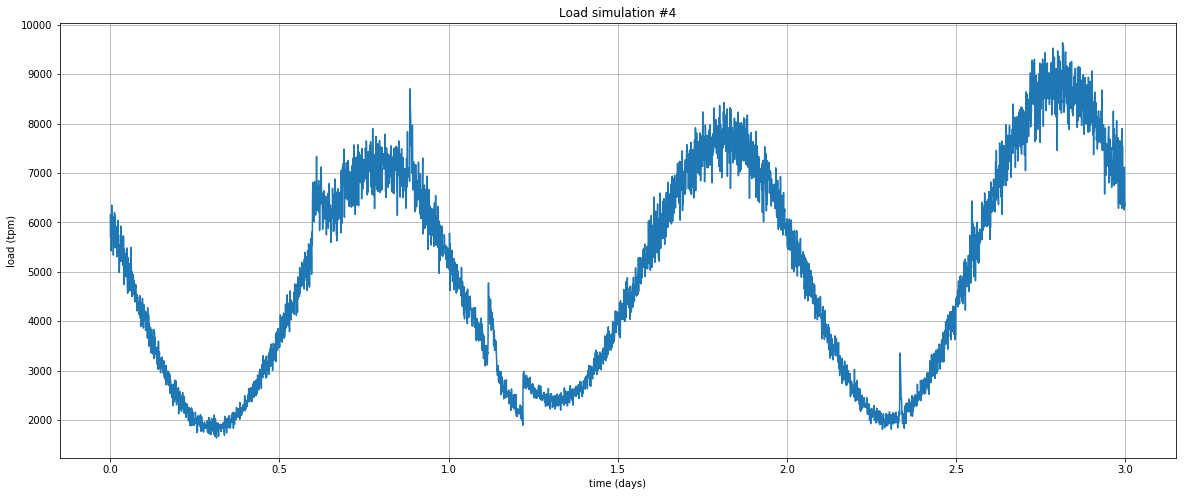

In [11]:
plt.rcParams["figure.figsize"] = (20,8)

for n in range(5):  # Draw 5 plots
    (x,y) = xy_data()
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='time (days)', ylabel='load (tpm)',
           title='Load simulation #%d' % n)
    ax.grid()
    plt.show()

## RL 알고리즘에 대한 사전 설정 구성

RL 훈련 작업을 구성하는 사전 설정은 `/src` 디렉토리에 업로드된 `preset-autoscale-ppo.py` 파일에 정의되어 있습니다. 사전 설정 파일을 사용하여 에이전트 파라메터들을 정의하여 특정 에이전트 알고리즘을 선택할 수 있습니다. 환경 파라메터를 설정하고, 스케줄 및 시각화 파라메터를 정의하고, 그래프 관리자를 정의할 수도 있습니다. 스케줄 사전 설정은 heat up 스텝, 주기적 평가 스텝, 평가 간의 훈련 단계를 정의합니다.

`RLCOACH_PRESET` 하이퍼 파라미터를 지정하여 런타임 시 이를 오버라이드할 수 있습니다. 또한 사용자 정의 하이퍼 파라미터들을 정의하는 데 사용할 수 있습니다.

In [12]:
!pygmentize src/preset-autoscale-ppo.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.architectures.layers import Dense
from rl_coach.base_parameters import VisualizationParameters, PresetValidationParameters, DistributedCoachSynchronizationType
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps, RunPhase
from rl_coach.environments.gym_environment import GymVectorEnvironment, mujoco_v2
from rl_coach.exploration_policies.e_greedy import EGreedyParameters
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

####################
# Graph Scheduling #
####################

schedule_params = ScheduleParameters()
schedule_params.improve_steps = TrainingSteps(int(5e5))
schedule_params.steps_between_evaluation_periods = EnvironmentSteps(50000)
schedule_params.evaluation_steps = EnvironmentEpisodes(5)
schedule_params.heatu

## 훈련 코드 작성 

훈련 코드는 /src 디렉토리에 업로드된 `“train-coach.py”`파일에 작성됩니다. 먼저 환경 파일과 사전 설정 파일을 가져온 다음 `main()` 함수를 정의하세요.

In [13]:
!pygmentize src/train-coach.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher
import tensorflow as tf
import shutil

class MyLauncher(SageMakerCoachPresetLauncher):

    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return 'preset-autoscale-ppo'

    def map_hyperparameter(self, name, value):
        """Here we configure some shortcut names for hyperparameters that we expect to use frequently.
        Essentially anything in the preset file can be overridden through a hyperparameter with a name 
        like "rl.agent_params.algorithm.etc".  
        """
        if name == "warmup_latency":
            return self.apply_hyperparameter("rl.env_params.additional_simulator_parameters.warmup_latency", value)
        if name == "discount": 
            return self.apply_hyperparameter("rl.agent_params.algorithm.discount", valu

## Python SDK 스크립트 모드를 사용하여 RL 모델 훈련

로컬 모드를 사용하는 경우 노트북 인스턴스에서 훈련이 실행됩니다. 훈련을 위해 SageMaker를 사용할 때 GPU 또는 CPU 인스턴스를 선택할 수 있습니다. RLEstimator는 RL 작업 훈련에 사용됩니다.

1. 환경, 사전 설정 및 교육 코드가 업로드되는 소스 디렉토리를 지정합니다.
2. 엔트리 포인트(entry point)를 훈련 코드로 지정합니다.
3. RL 툴킷 및 프레임 워크를 선택합니다. 이는 RL 컨테이너의 ECR 경로로 자동 확인됩니다.
4. 인스턴스 수, 작업 이름(job name), 출력에 대한 S3 경로 및 작업 이름과 같은 훈련 파라메터들을 정의합니다.
5. RL 에이전트 알고리즘의 하이퍼파라미터를 지정합니다. `RLCOACH_PRESET`을 사용하여 사용하려는 RL 에이전트 알고리즘을 지정할 수 있습니다.
6. [선택 사항] 여러분의 로그에서 캡처할 지표(metric)를 선택합니다. CloudWatch 및 SageMaker Notebook에서도 시각화할 수 있습니다. 지표는 정규식 매칭을 사용하여 정의합니다.

In [14]:
%%time

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.m4.xlarge"
        
estimator = RLEstimator(entry_point="train-coach.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          "RLCOACH_PRESET": "preset-autoscale-ppo",
                          "rl.agent_params.algorithm.discount": 0.9,
                          "rl.evaluation_steps:EnvironmentEpisodes": 8,
                          # save model for deployment
                          "save_model": 1
                        }
                    )
estimator.fit()

2020-03-26 01:15:06 Starting - Starting the training job...
2020-03-26 01:15:08 Starting - Launching requested ML instances......
2020-03-26 01:16:09 Starting - Preparing the instances for training...
2020-03-26 01:17:06 Downloading - Downloading input data...
2020-03-26 01:17:28 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-26 01:17:50,116 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-26 01:17:50,119 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-26 01:17:50,294 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-26 01:17:50,308 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {},
    "current_host": "algo-1",
   

Heatup> Name=main_level/agent, Worker=0, Episode=1, Total reward=-183717.02, Steps=10001, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=2, Total reward=-245497.95, Steps=20002, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=3, Total reward=-150159.19, Steps=30003, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=4, Total reward=-239905.05, Steps=40004, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=5, Total reward=-215950.24, Steps=50005, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=6, Total reward=-157161.61, Steps=60006, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=7, Total reward=-325581.34, Steps=70007, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=8, Total reward=-120715.92, Steps=80008, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=9, Total reward=-170700.81, Steps=90009, Training iteration=0
H

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-71327.0, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-95197.21, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-94695.45, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-64427.66, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-41789.8, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-41602.73, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-83900.82, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-99938.13, Steps=200015, Training iteration=4
## agent: Finished evaluation phase. Success rate = 0.0, Avg T

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=14443.19, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=16473.34, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=15515.26, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-576922.86, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=20580.59, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-488767.32, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-585998.73, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-271165.4, Steps=250015, Training iteration=8
## agent: Finished evaluation phase. Success rate = 0.0, Avg 

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=4644.37, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=17097.45, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=3046.69, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=10822.74, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=11665.63, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=6829.53, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=5827.86, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=2393.87, Steps=300015, Training iteration=12
## agent: Finished evaluation phase. Success rate = 0.0, Avg Tota

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-5033.18, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-2378.54, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-8798.9, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-5592.2, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=5698.0, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-6471.99, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-15182.26, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-17531.59, Steps=350015, Training iteration=16
## agent: Finished evaluation phase. Success rate = 0.0, Avg T

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-192327.28, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-33554.93, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-187645.54, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-233378.53, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-305274.89, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-101163.31, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-148046.6, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-155448.56, Steps=400015, Training iteration=20
## agent: Finished evaluation phase. Success r

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-2560.62, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-141986.7, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=15551.44, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=16724.18, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=12401.15, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-180568.63, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=17081.69, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=16906.05, Steps=450015, Training iteration=24
## agent: Finished evaluation phase. Success rate = 0.0, 

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=2223.5, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=13665.35, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=14399.55, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-334323.66, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-134729.54, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-55984.78, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=5452.77, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=4242.3, Steps=500015, Training iteration=28
## agent: Finished evaluation phase. Success rate = 0.0, Avg

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=21343.25, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=2223.2, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=6594.84, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-478019.66, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=20998.51, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=16223.86, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=12155.74, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=6782.29, Steps=550015, Training iteration=32
## agent: Finished evaluation phase. Success rate = 0.0, Avg T

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=8894.98, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=14722.93, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=9583.29, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=14110.91, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=11090.06, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-32003.3, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=9593.36, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=14807.53, Steps=600015, Training iteration=36
## agent: Finished evaluation phase. Success rate = 0.0, Avg To

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-39835.52, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-41223.32, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=19290.74, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=16468.88, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=5232.93, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=10530.45, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=7294.52, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=4524.02, Steps=650015, Training iteration=40
## agent: Finished evaluation phase. Success rate = 0.0, Avg 

## 중간 훈련 결과 및 모델 체크 포인트 저장

위의 훈련 작업의 출력은 로컬 디렉토리(`로컬` 모드) 또는 S3(`SageMaker`) 모드로 저장됩니다.

In [15]:
%%time

job_name=estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-auto-scaling-2020-03-26-01-15-06-241
S3 job path: s3://sagemaker-us-west-2-143656149352/rl-auto-scaling-2020-03-26-01-15-06-241
Output.tar.gz location: s3://sagemaker-us-west-2-143656149352/rl-auto-scaling-2020-03-26-01-15-06-241/output/output.tar.gz
Intermediate folder path: s3://sagemaker-us-west-2-143656149352/rl-auto-scaling-2020-03-26-01-15-06-241/output/intermediate/
Create local folder /tmp/rl-auto-scaling-2020-03-26-01-15-06-241
CPU times: user 2.96 ms, sys: 4.45 ms, total: 7.4 ms
Wall time: 8.11 ms


## 시각화
### 학습률 plot

아래 코드를 사용하여 훈련 중 보상을 볼 수 있습니다. 이 시각화는 보상으로 표현된 모델의 성능이 시간이 지남에 따라 어떻게 개선되었는지 이해하는 데 도움이 됩니다.

Waiting for s3://sagemaker-us-west-2-143656149352/rl-auto-scaling-2020-03-26-01-15-06-241/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


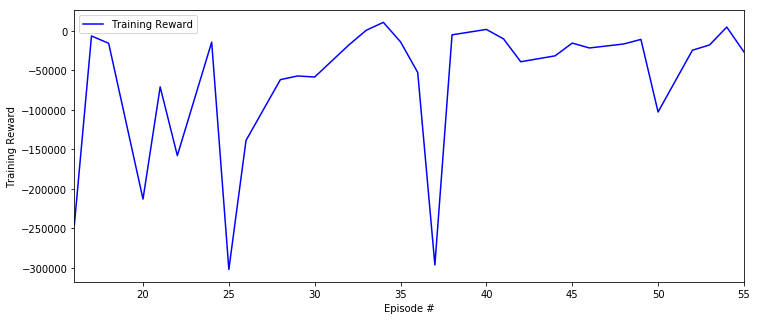

In [16]:
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=['Training Reward'])
x_axis = 'Episode #'
y_axis = 'Training Reward'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

## RL 모델 평가

최신 체크포인트 모델을 사용하여 RL 에이전트에 대한 평가를 실행합니다.

### 체크포인트  모델 로드

이전에 훈련된 모델의 체크포인트 데이터는 `checkpoint` 채널에서 평가 및 추론을 위해 전달됩니다. `로컬` 모드에서는 단순히 로컬 디렉토리를 사용할 수 있지만, `SageMaker` 모드에서는 먼저 S3으로 이동해야 합니다.

TensorFlow 스토어 ckeckpoint 파일에는 생성 시점부터의 절대 경로가 포함되므로 ([issue](https://github.com/tensorflow/tensorflow/issues/9146) 참조) 절대 경로를 상대 경로로 바꿔야 합니다. 이것은 `evaluate-coach.py`내에서 구현됩니다.

In [17]:
%%time

wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)  

if not os.path.isfile("{}/output.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File output.tar.gz not found")
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))

if local_mode:
    checkpoint_dir = "{}/data/checkpoint".format(tmp_dir)
else:
    checkpoint_dir = "{}/checkpoint".format(tmp_dir)

print("Checkpoint directory {}".format(checkpoint_dir))

Waiting for s3://sagemaker-us-west-2-143656149352/rl-auto-scaling-2020-03-26-01-15-06-241/output/output.tar.gz...
Checkpoint directory /tmp/rl-auto-scaling-2020-03-26-01-15-06-241/checkpoint
CPU times: user 113 ms, sys: 25.3 ms, total: 138 ms
Wall time: 621 ms


In [18]:
%%time

if local_mode:
    checkpoint_path = 'file://{}'.format(checkpoint_dir)
    print("Local checkpoint file path: {}".format(checkpoint_path))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

S3 checkpoint file path: s3://sagemaker-us-west-2-143656149352/rl-auto-scaling-2020-03-26-01-15-06-241/checkpoint/
CPU times: user 2.55 ms, sys: 4.4 ms, total: 6.96 ms
Wall time: 1.28 s


### 평가 수행

체크포인트 모델을 사용하여 평가를 수행합니다.

In [19]:
%%time

estimator_eval = RLEstimator(role=role,
                      source_dir='src/',
                      dependencies=["common/sagemaker_rl"],
                      toolkit=RLToolkit.COACH,
                      toolkit_version='0.11.0',
                      framework=RLFramework.TENSORFLOW,
                      entry_point="evaluate-coach.py",
                      train_instance_count=1,
                      train_instance_type=instance_type,
                      hyperparameters = {
                                 "RLCOACH_PRESET": "preset-autoscale-ppo",
                                 "evaluate_steps": 10001*2 # evaluate on 2 episodes
                             }
                    )
estimator_eval.fit({'checkpoint': checkpoint_path})

2020-03-26 01:53:46 Starting - Starting the training job...
2020-03-26 01:53:47 Starting - Launching requested ML instances......
2020-03-26 01:54:48 Starting - Preparing the instances for training......
2020-03-26 01:55:51 Downloading - Downloading input data...
2020-03-26 01:56:37 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-26 01:56:38,571 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-26 01:56:38,575 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-26 01:56:38,707 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-26 01:56:38,721 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {
        

Testing> Name=main_level/agent, Worker=0, Episode=1, Total reward=21676.35, Steps=10001, Training iteration=0

2020-03-26 01:57:12 Uploading - Uploading generated training modelTesting> Name=main_level/agent, Worker=0, Episode=2, Total reward=11426.94, Steps=20002, Training iteration=0
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 16551.64
2020-03-26 01:57:10,641 sagemaker-containers INFO     Reporting training SUCCESS

2020-03-26 01:57:20 Completed - Training job completed
Training seconds: 89
Billable seconds: 89
CPU times: user 794 ms, sys: 33.6 ms, total: 828 ms
Wall time: 4min 13s


## 호스팅
훈련이 완료되면 훈련된 모델을 Amazon SageMaker 실시간 호스팅 엔드포인트로 배포할 수 있습니다. 이를 통해 모델로부터 예측(또는 추론)을 수행할 수 있습니다. 훈련할 때 사용한 것과 동일한 인스턴스(또는 인스턴스 유형)를 호스팅할 필요는 없습니다. 엔드 포인트 배포는 다음과 같이 수행할 수 있습니다.

In [20]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

---------!

### 추론

훈련된 모델이 실행 중인 엔드포인트에 배포되었으므로, 이 엔드포인트를 추론에 사용할 수 있습니다. 입력 형식은 정의된 환경에서 `observation_space`의 형식과 일치해야 합니다. 이 예에서 observation spaces는 이전 관측치와 현재 관측치로 구성된 25차원 벡터입니다. 공간을 위해 이 데모에는 사소한 구성 프로세스가 포함되어 있지 않습니다. 대신, 아래에 더미 입력을 제공합니다. 자세한 내용은 `src/autoscalesim.py`를 확인하세요.

In [21]:
observation = np.arange(1, 26)
action = predictor.predict(observation)
print(action)

{'predictions': [[0.00284312, -0.000183001]]}


### 엔드포인트 삭제

엔드 포인트를 실행하면 비용이 발생합니다. 따라서 핸즈온 시에는 과금을 피하기 위해 정리 작업으로 엔드 포인트를 삭제해야 합니다.

In [22]:
predictor.delete_endpoint()